In [1]:
from torch import *
from torch.nn.functional import one_hot, pad
import torch
import seaborn
import celluloid
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython import get_ipython
seaborn.set_context("talk")
def tensor_html(obj):
    return '<p class="tensor_out"> > %s</p>' % obj.detach().numpy()

ipython = get_ipython()
if ipython is not None:
    html_formatter = ipython.display_formatter.formatters['text/html']
    html_formatter.for_type(Tensor, tensor_html)
    
def stdN(means, points):
    I = torch.eye(means.shape[-1])
    return torch.distributions.MultivariateNormal(means, I[None, :, :]).log_prob(points[:, None, :]).exp()

def plot_coin(x):
    return plt.bar(["Tails", "Heads"], x.detach())

def plot_prob(x):
    plt.ylim([0, 1])
    return plt.bar(["Prob"], x.detach())

# Differential Inference: A Criminally Underused Tool

[@srush](https://twitter.com/srush_nlp) 


## Style

This talk is a live working PyTorch notebook.

https://github.com/srush/ProbTalk

## Preface

> It is bizarre that the main technical contribution of so many papers
> seems to be something that computers can do for us automatically.
> We would be better off just considering autodiff part of the
> optimization procedure, and directly plugging in the objective
> function.  In my opinion, this is actually harmful to the field.
- Justin Domke, 2009

## Differential Inference

Goal: Use differentiation to perform complex probabilistic inference.

## Disclaimer

This talk contains no new research:  

* A Differential Approach to Inference in Bayesian Networks (Darwiche, 2000)

Also:

* Autoconj: Recognizing and Exploiting Conjugacy Without a Domain-Specific Language (Hoffman, Johnson, Tran, 2018)
* A Tutorial on Probabilistic Circuits  (Antonio Vergari, Robert Peharz, YooJung Choi, and Guy Van den Broeck, AAAI 2020)

# Part 1: Counting the Hard Way

## Problem

> I have two coins, how many different ways can I place them?


Answer:

* T T
* T H
* H T
* H H

## Observed Coins

Let $\lambda^1$ represent Coin 1:

* $\lambda^1= \delta_0$ as tails
* $\lambda^1 = \delta_1$ as heads 

In [2]:

def ovar(size, val):
    return one_hot(torch.tensor(val), size).float()
tails, heads = ovar(2, 0), ovar(2, 1)
tails

tensor([1., 0.])


## Latent Coins

If we do not know the state, we use $\lambda^1 = \mathbf{1}$.

In [3]:

def lvar(size):
    return ones(size, requires_grad=True).float()

def coin():
    return lvar(2)

l_coin1, l_coin2 = coin(), coin()
l_coin1

tensor([1., 1.], requires_grad=True)

## Counting

We can use this to count.

 $$f(\lambda) = \lambda_0^1  \lambda_0^2 + \lambda_0^1  \lambda_1^2 + \lambda_1^1  \lambda_0^2 + \lambda_1^1  \lambda_1^2$$

In [4]:

def f(l_coin1, l_coin2):
    return (l_coin1[None, :] * l_coin2[:, None]).sum()

# Total number of arrangements:
f(coin(), coin())

tensor(4., grad_fn=<SumBackward0>)

## Constrained Counting 

We can also count under a known constraint. Starting from:

$$f(\lambda) = \lambda_0^1  \lambda_0^2 + \lambda_0^1  \lambda_1^2 + \lambda_1^1  \lambda_0^2 + \lambda_1^1  \lambda_1^2$$


Let $\lambda^2 = \delta_0$, $$f(\lambda) = \lambda_0^1 + \lambda_1^1$$

In [5]:

# Total number of arrangements with Coin2 tails:
f(coin(), tails)

tensor(2., grad_fn=<SumBackward0>)


## Differential Counting

Even better we can also count under all constraints. Starting from:

$$f(\lambda)=\lambda_0^1\lambda_0^2 + \lambda_0^1  \lambda_1^2 + \lambda_1^1  \lambda_0^2 + \lambda_1^1  \lambda_1^2$$

Derivative gives

$$f'_{\lambda_0^1}(\lambda)=\lambda_0^2+\lambda_1^2$$

In [6]:

l_coin1, l_coin2 = coin(), coin()
f(l_coin1, l_coin2).backward()

# Total number of arrangements with Coin1 tails:
l_coin1.grad[0]

tensor(2.)


## Differential Counting 2


Derivative gives

$$f'_{\lambda_0^2}(\lambda)=\lambda_0^1+\lambda_1^1$$
$$f'_{\lambda_1^2}(\lambda)=\lambda_0^1+\lambda_1^1$$

In [7]:

# Total number of arrangements based on Coin2:
l_coin2.grad


tensor([2., 2.])

## Problem: Counting with  Branching 

> Place Coin 1.
>
> * If tails, Coin 2 must be heads.
> * If heads, Coin 2 can be either.


Answer:

* T H
* H T
* H H


## Counting Function

Generative count for process,

$$f(\lambda) = \lambda_0^1  \lambda_1^2 + (\sum_j \lambda_1^1 \lambda_j^2)$$

In [8]:

def f(l_coin1, l_coin2):
    # If tails, Coin 2 must be heads
    e1 = l_coin1[0] * l_coin2[1]
    
    # If heads, Coin 2 can be either
    e2 = (l_coin1[1] * l_coin2).sum()
    
    return e1 + e2 

## Counting

Number of ways the coins can land. 

In [9]:

l_coin1, l_coin2 = coin(), coin()
f(l_coin1, l_coin2)

tensor(3., grad_fn=<AddBackward0>)


## Query

Number of ways the coins can land. 
* Coin 1 Tails:  $$f'_{\lambda^1_0}(\lambda)=\lambda_1^2$$
* Coin 1 Heads: $$f'_{\lambda^1_1}(\lambda)=\sum_j \lambda_j^2$$

In [10]:

f(l_coin1, l_coin2).backward()
l_coin1.grad


tensor([1., 2.])


## Constrained Query

Number of ways the coins can land, depending on the first.

* Coin 2 Tails:  $$f'_{\lambda^2_0}(\lambda)=\lambda_1^1$$
* Coin 2 Heads: $$f'_{\lambda^2_1}(\lambda)=\lambda_0^0 + \lambda_1^1$$

In [11]:

l_coin2 = coin()
f(tails, l_coin2).backward()
l_coin2.grad

tensor([0., 1.])

# Part 2: Probabilistic Inference


## Differential Inference

We specify the Joint  $$p(x_1,x_2)$$

For observed evidence $e$, we get for free:

* Marginal  $$p(x_2=e)$$
* Constrained Joint  $$p(x_1,x_2=e)$$
* Conditional  $$p(x_1|x_2=e)$$


## Problem: More Coins the Hard Way

> Flip two fair coins.

In [12]:

fair_coin = torch.ones(2) / 2.

## Joint

Function for joint probability
$$p(x_1,x_2)$$

$$f(\lambda) = \sum_{i,j} \lambda^1_i \lambda^2_j\  p(x_1=i, x_2=j)$$

In [13]:


def f(l_coin1, l_coin2):
    flip1 = fair_coin * l_coin1
    flip2 = fair_coin * l_coin2
    return (flip1[:, None] * flip2[None, :]).sum()

## Joint Probability

Using the function with $\delta_0$ and $\delta_1$, 
 $$p(x_1=1, x_2=0)$$ 

In [14]:

f(heads, tails)


tensor(0.2500)

## Marginal Probability

Using the function to marginalize with $\mathbf{1}$, 
$$p(x_2=0)$$

$$f(\lambda^1 =\mathbf{1}, \lambda^2 = \delta_0) = \sum_{i} \lambda^1_i p(x_1=i, x_2=0) $$

In [15]:
l_coin1, o_coin2 = coin(), tails
f(l_coin1, o_coin2)

tensor(0.5000, grad_fn=<SumBackward0>)

## Constrained Joint

$$f(\lambda^1 =\mathbf{1}, \lambda^2 = \delta_0) = \sum_{i} \lambda^1_i p(x_1=i, x_2=0) $$

$$f'_{\lambda^1_0}(\mathbf{1}, \delta_0)= p(x_1=0, x_2=0)\ |\   f'_{\lambda^1_1}(\mathbf{1}, \delta_0) = p(x_1=1, x_2=0)$$

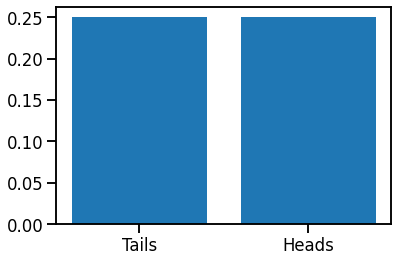

In [16]:


l_coin1, o_coin2 = coin(), tails
f(l_coin1, o_coin2).backward()
plot_coin(l_coin1.grad);


## Conditional

With Bayes' Rule,  $$p(x_1 | x_2=e) = \frac{p(x_1, x_2=e)}{p(x_2=e)}$$

* Numerator is constrained joint
* Denominator is marginal
* Conditional is:

$$f'(\lambda) / f(\lambda)$$


## Conditional Computation

Use log trick, $$(\log f)' = f'(\mathbf{1}, \delta_1) / f(\mathbf{1}, \delta_1) = p(x_1 | x_2=1)$$

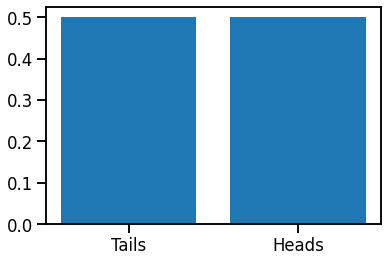

In [17]:

l_coin1 = coin()
f(l_coin1, heads).log().backward()
plot_coin(l_coin1.grad);

## Part 3: Fancy Coins



## Problem: Conditional Coins
> Flip Coin 1.
> * If tails, place Coin 2 as heads.
> * If heads, flip Coin 2.

In [18]:

def f(l_coin1, l_coin2):
    # Flip Coin 1
    flip1 = fair_coin * l_coin1
    
    # If tails, place Coin 2 as heads.
    e1 = flip1[0] * l_coin2[1]
    
    # If heads, flip Coin 2.
    flip2 = l_coin2 * fair_coin
    e2 = (flip1[1] * flip2).sum()
    
    return e1 + e2 


## Conditional Inference

$$p(x_1 | x_2=0)$$

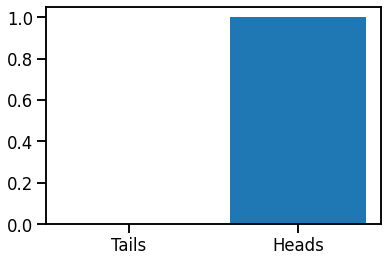

In [19]:

l_coin1 = coin()
f(l_coin1, tails).log().backward()
plot_coin(l_coin1.grad);

## Problem: Coins and Dice

> I flipped a fair coin, if it was heads I rolled a fair die,
> otherwise I rolled a weighted die.

In [20]:

COIN, DICE = 2, 6
dice = lambda: lvar(6)
fair_die = ones(DICE) / 6.0
weighted_die = 0.8 * one_hot(tensor(3), DICE) + 0.2 * fair_die


## Generative Story:

> I flipped a fair coin, if it was heads I rolled a fair die,
> otherwise I rolled a weighted die.

In [21]:

def f(l_flip, l_die):
    # I flipped a fair coin
    x_coin = l_flip * fair_coin
    
    # If it was heads I rolled a fair die.
    roll1 = l_die * fair_die
    e1 = x_coin[1] * roll1

    # If it was tails I rolled a weighted die.
    roll2 = l_die * weighted_die
    e2 = x_coin[0] * roll2
    return (e1 + e2).sum()

## Dice from Coin 1

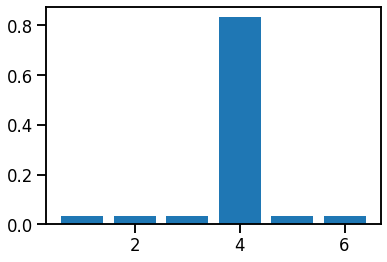

In [22]:

l_die = dice()
f(tails, l_die).log().backward()
plt.bar(arange(0, DICE)+1, l_die.grad);

## Coin from Dice 1

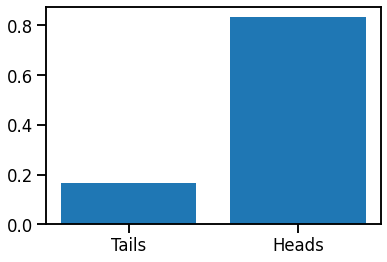

In [23]:

l_coin, o_die = coin(), ovar(DICE, 5)
f(l_coin, o_die).log().backward()
plot_coin(l_coin.grad);

## Coin from Dice 2

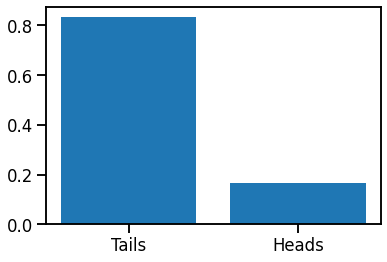

In [24]:

l_coin, o_die = coin(), ovar(DICE, 3)
f(l_coin, o_die).log().backward()
plot_coin(l_coin.grad);

## Dice Marginal

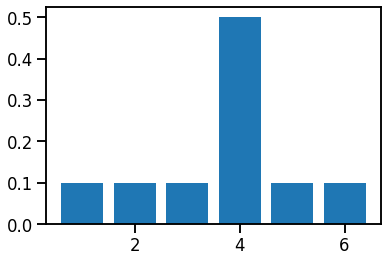

In [25]:

l_coin, l_die = coin(), dice()
f(l_coin, l_die).log().backward()
plt.bar(arange(0, 6)+1, l_die.grad);

## Problem: Summing Up

Can construct more complex operations.

> Flip two coins, how many heads?

$$ C = X_1 + X_2$$

In [26]:

def padconv(x, y):
    "1D conv for count"
    s = x.shape[0] 
    return x.flip(0) @ pad(y, (s-1, s-1)).unfold(0, s, 1).T



## Sum of Variables

Let $\lambda^c$ be the sum of two uniform variables.

$$f(\lambda)=\lambda^c_0 \lambda^1_0 \lambda^2_0 p(x_1=0,x_2=0 )  + ...$$

In [27]:

def f(l1, l2, l_count):
    s = l1.shape[0]
    d = ones(s) / s
    e1 = d * l1
    e2 = d * l2
    return (padconv(e1, e2) * l_count).sum()


## Sum of Coins

Let $\lambda_c$ be the sum of two uniform variables.

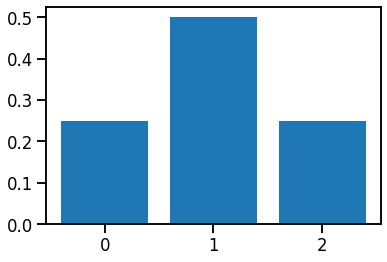

In [28]:

l_coin1, l_coin2, l_count = coin(), coin(), lvar(3)
f(l_coin1, l_coin2, l_count).log().backward()
plt.bar(arange(0, 3), l_count.grad);


## Sum of Dice

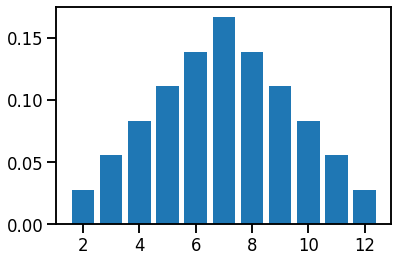

In [29]:

l_die1, l_die2, l_count = dice(), dice(), lvar(11)
f(l_die1, l_die2, l_count).log().backward()
l_count.grad
plt.bar(arange(2, 13), l_count.grad);


## Dice Conditioned on Sum

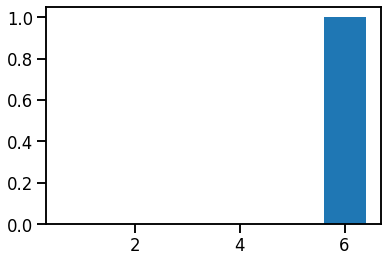

In [30]:

l_die1, l_die2, o_count = dice(), dice(), ovar(11, 10)
f(l_die1, l_die2, o_count).log().backward()
plt.bar(arange(0,6 )+1, l_die2.grad);

## Part 4: Real Models


## Problem: Graphical Models


![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/SimpleBayesNet.svg/1920px-SimpleBayesNet.svg.png) 


## Conditional Probabilities

In [31]:

def bern(p):
    return [1.0-p, p]

In [32]:

# p(R)
rain = tensor(bern(0.2))

# p(S | R)
sprink_rain = tensor([bern(0.4), bern(0.01)]).T

# p(W | S, R)
wet = tensor([[bern(0.0), bern(0.8)],
              [bern(0.9), bern(0.99)]]).permute(2, 0, 1)

## Bayes Net


Construct the joint probability of the system. 

In [33]:
def f(l_rain, l_sprink, l_wet):
    # r ~ P(R)
    e_r = l_rain * rain
    # s ~ P(S | R=r)
    e_sr = l_sprink[:, None] * sprink_rain * e_r
    # w ~ P(W | S=s, R=r)
    e_w = l_wet[:, None, None] * wet * e_sr
    return e_w.sum()

## Joint Probability

$$p(R=r, S=s, W=w)$$

In [34]:

o_rain, o_sprinkler, o_wet = ovar(2, 1), ovar(2, 1), ovar(2, 1)
f(o_rain, o_sprinkler, o_wet)

tensor(0.0020)

## Marginal Inference

$$p(R)$$

In [35]:

l_rain, l_sprinkler, l_wet = lvar(2), lvar(2), lvar(2)
f(l_rain, l_sprinkler, l_wet).log().backward()
l_rain.grad

tensor([0.8000, 0.2000])

## Conditional Inference

$$p(R | W=1)$$

In [36]:

l_rain, l_sprinkler, o_wet = lvar(2), lvar(2), ovar(2, 1)
f(l_rain, l_sprinkler, o_wet).log().backward()
l_rain.grad

tensor([0.6423, 0.3577])


## Problem: Gaussian Mixture Model

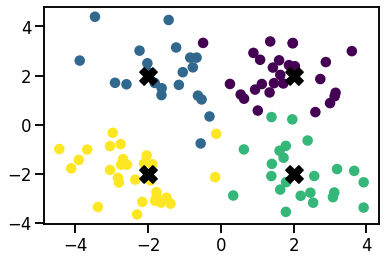

In [37]:

BATCH, DIM, CLASSES = 100, 2, 4
I = eye(DIM)
N = torch.distributions.MultivariateNormal
y = randint(0, CLASSES, (BATCH,))
d_means = torch.tensor([[2, 2.], [-2, 2.], [2, -2], [-2, -2.]])
d_prior = ones(CLASSES) / CLASSES
X = N(d_means, I[None, :, :]).sample((BATCH,))[torch.arange(BATCH), y]

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(d_means[:, 0],  d_means[:, 1], s= 300, marker="X", color="black");



## Generative Model

> Generate a class, generate point from Gaussian.

In [38]:

def gmm(X, l_class, d_prior, d_means):
    x_class = l_class * d_prior
    return (stdN(d_means, X) * x_class).sum(-1)


## GMM - Expectation-Maximization

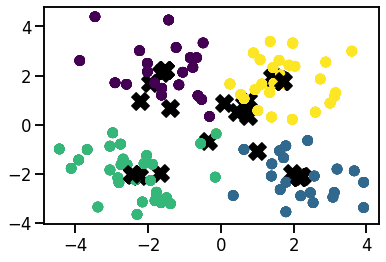

In [39]:

fig, ax = plt.subplots(nrows=1, ncols=1)
camera = celluloid.Camera(fig)
mu = torch.rand(CLASSES, DIM)
for epoch in arange(0, 10):
    l_class = lvar((X.shape[0], CLASSES))
    gmm(X, l_class, d_prior, mu).log().sum().backward()
    q = l_class.grad
    ax.scatter(X[:, 0], X[:, 1], c=q.argmax(1))
    ax.scatter(mu[:, 0],  mu[:, 1], s= 300, marker="X", color="black")
    camera.snap()    
    mu = (q[:, :, None] * X[:, None, :]).sum(0) / q.sum(0)[:, None]

In [40]:

HTML(camera.animate(interval=300, repeat_delay=2000).to_jshtml())


## Problem: Hidden Markov Models (HMM)


Joint probability ($f$) of hidden states and observations.

In [41]:
def HMM(l_O, l_H, params):
    T, E, P = params
    p = 1.0
    for l in arange(0, l_O.shape[0]):
        P = ((l_H[l] * P)[:, None] * E) @ l_O[l] @ T
        p = p * P.sum()
        P = P / P.sum()
    return (p * P.sum())

## Example: HMM

A simple HMM with circulant transitions

In [42]:

STATES, OBS = 500, 500
E, T = eye(STATES), zeros(STATES, STATES), 
P = ones(STATES) / STATES
kernel = arange(-6, 7)[:, None]
s = arange(STATES)
T[s, (s + kernel).remainder(STATES)] = 1. / kernel.shape[0]
params = T, E, P

## Differential Inference
 Inference over states with some known observations

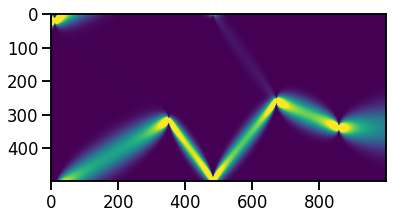

In [43]:

fig, ax = plt.subplots(nrows=1, ncols=1)
camera = celluloid.Camera(fig)

def ovarN(x, N=OBS): return  one_hot(x, N)[None].float()
def lvarN(s, N=OBS): return  ones(s, N, requires_grad=True)

start = lvarN(1000).detach()
start.requires_grad_(False)
for i in arange(0, 5): 
    start[randint(1000, (1,))[0], :] = ovarN(randint(STATES, (1,))[0])
    states = lvar((start.shape[0], STATES))

    # Run and plot...
    HMM(start, states, params).log().backward()
    ax.imshow(states.grad.transpose(1, 0), vmax=0.02)
    camera.snap()

In [44]:

HTML(camera.animate(interval=300, repeat_delay=2000).to_jshtml())



## Conclusion


 * Derivatives: Not just for learning
 * Often no need for specialized algorithms or languages
 * Can borrow efficient implementations

> "Counting with Style"




## What comes next?


 * Continuous probability
 * Entropies and Divergences
 * Complex Sampling
 * Probabilistic Circuits

So much more...


## Thanks!




In [45]:
HTML('<link rel="stylesheet" href="custom.css">')